In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset.zip -d /content/dataset/

Archive:  /content/drive/MyDrive/dataset.zip
   creating: /content/dataset/dataset/type1/
  inflating: /content/dataset/dataset/type1/img1.jpg  
  inflating: /content/dataset/dataset/type1/img10.jpg  
  inflating: /content/dataset/dataset/type1/img100.jpg  
  inflating: /content/dataset/dataset/type1/img101.jpg  
  inflating: /content/dataset/dataset/type1/img102.jpg  
  inflating: /content/dataset/dataset/type1/img103.jpg  
  inflating: /content/dataset/dataset/type1/img104.jpg  
  inflating: /content/dataset/dataset/type1/img105.jpg  
  inflating: /content/dataset/dataset/type1/img106.jpg  
  inflating: /content/dataset/dataset/type1/img107.jpg  
  inflating: /content/dataset/dataset/type1/img108.jpg  
  inflating: /content/dataset/dataset/type1/img109.jpg  
  inflating: /content/dataset/dataset/type1/img11.jpg  
  inflating: /content/dataset/dataset/type1/img110.jpg  
  inflating: /content/dataset/dataset/type1/img111.jpg  
  inflating: /content/dataset/dataset/type1/img112.jpg  
  

In [ ]:
!pip install numpy opencv-python scikit-image

In [ ]:
import os
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time

# function to remove the background and keep only the arecanut
def remove_background(img):
    # Define lower and upper limits for white color
    lower = np.array([200, 200, 200])
    upper = np.array([255, 255, 255])

    # Create mask to only select white areas
    thresh = cv2.inRange(img, lower, upper)

    # Apply morphology to close gaps in the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Invert the morphed image to get the mask
    mask = 255 - morph

    # Apply mask to the image
    result = cv2.bitwise_and(img, img, mask=mask)

    # Set background to black
    img[mask == 0] = [0, 0, 0]

    return result

def extract_color_features(img):
    # Convert image to HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    h, s, v = cv2.split(hsv_img)

    features = []
    for channel in [h, s, v]:
        mean = np.mean(channel)
        std = np.std(channel)

        # Ensure no division by zero in skewness calculation
        if std == 0:
            skewness = 0
        else:
            skewness = np.mean((channel - mean) ** 3) ** (1./3)

        # Check for NaN and handle it
        if np.isnan(mean):
            mean = 0
        if np.isnan(std):
            std = 0
        if np.isnan(skewness):
            skewness = 0

        features.extend([mean, std, skewness])
    return np.array(features)


def extract_texture_features(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    texture_features = np.array([contrast, dissimilarity, homogeneity, energy, correlation, asm])
    return texture_features

def extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")
    img_no_bg = remove_background(img)
    color_features = extract_color_features(img_no_bg)
    texture_features = extract_texture_features(img_no_bg)
    features = np.concatenate((color_features, texture_features))
    return features

def create_dataset(data_dir):
    features = []
    labels = []
    class_labels = os.listdir(data_dir)
    for label in class_labels:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            print(f"Processing directory: {class_dir}")
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        print(f"Processing image: {img_path}")
                        start_time = time.time()
                        img_features = extract_features(img_path)
                        features.append(img_features)
                        labels.append(label)
                        print(f"Processed {img_path} in {time.time() - start_time:.2f} seconds")
                    except Exception as e:
                        print(f"Error processing image {img_path}: {e}")
    return np.array(features), np.array(labels)

# Directory containing  dataset
data_dir = '/content/dataset/dataset/'  # Ensure this path is correct

# Create the dataset
start_time = time.time()
features, labels = create_dataset(data_dir)
print(f"Dataset created in {time.time() - start_time:.2f} seconds")

# Check if features and labels are empty
if len(features) == 0 or len(labels) == 0:
    print("No features or labels were extracted. Please check your dataset and paths.")
else:
    # Encode labels
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    # Create a DataFrame
    df_features = pd.DataFrame(features)
    df_labels = pd.DataFrame(labels_encoded, columns=['label'])

    # Concatenate features and labels
    df = pd.concat([df_features, df_labels], axis=1)

    # Save to CSV
    df.to_csv('/content/features_labels.csv', index=False)
    print("Features and labels saved to CSV.")


Processing directory: /content/dataset/dataset/type2
Processing image: /content/dataset/dataset/type2/img14.jpg
Processed /content/dataset/dataset/type2/img14.jpg in 5.48 seconds
Processing image: /content/dataset/dataset/type2/img27.jpg
Processed /content/dataset/dataset/type2/img27.jpg in 4.03 seconds
Processing image: /content/dataset/dataset/type2/img56.jpg
Processed /content/dataset/dataset/type2/img56.jpg in 2.61 seconds
Processing image: /content/dataset/dataset/type2/img13.jpg
Processed /content/dataset/dataset/type2/img13.jpg in 3.49 seconds
Processing image: /content/dataset/dataset/type2/img4.jpg
Processed /content/dataset/dataset/type2/img4.jpg in 2.67 seconds
Processing image: /content/dataset/dataset/type2/img75.jpg


<ipython-input-30-81fc12ed5d53>:50: RuntimeWarning: invalid value encountered in scalar power
  skewness = np.mean((channel - mean) ** 3) ** (1./3)


Processed /content/dataset/dataset/type2/img75.jpg in 2.00 seconds
Processing image: /content/dataset/dataset/type2/img3.jpg
Processed /content/dataset/dataset/type2/img3.jpg in 2.34 seconds
Processing image: /content/dataset/dataset/type2/img10.jpg
Processed /content/dataset/dataset/type2/img10.jpg in 2.27 seconds
Processing image: /content/dataset/dataset/type2/img112.jpg
Processed /content/dataset/dataset/type2/img112.jpg in 2.36 seconds
Processing image: /content/dataset/dataset/type2/img117.jpg
Processed /content/dataset/dataset/type2/img117.jpg in 3.32 seconds
Processing image: /content/dataset/dataset/type2/img54.jpg
Processed /content/dataset/dataset/type2/img54.jpg in 2.76 seconds
Processing image: /content/dataset/dataset/type2/img101.jpg
Processed /content/dataset/dataset/type2/img101.jpg in 2.26 seconds
Processing image: /content/dataset/dataset/type2/img1.jpg
Processed /content/dataset/dataset/type2/img1.jpg in 2.32 seconds
Processing image: /content/dataset/dataset/type2/

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


data = pd.read_csv('/content/drive/MyDrive/features_labels (4).csv')


X = data.drop(columns=['label'])
y = data['label']

if X.isnull().values.any():
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
else:
    X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)




Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        23
           1       0.83      1.00      0.91        29
           2       1.00      0.96      0.98        26
           3       1.00      1.00      1.00        18

    accuracy                           0.94        96
   macro avg       0.96      0.94      0.94        96
weighted avg       0.95      0.94      0.94        96



In [ ]:
import joblib

joblib.dump(svm_classifier, 'svm_model.joblib')

joblib.dump(scaler, 'scaler.joblib')

print("Model and scaler saved.")


Model and scaler saved.


<ipython-input-2-36f2503cb655>:39: RuntimeWarning: invalid value encountered in scalar power
  skewness = np.mean((channel - mean) ** 3) ** (1./3)


Predicted label for the new image: gotu


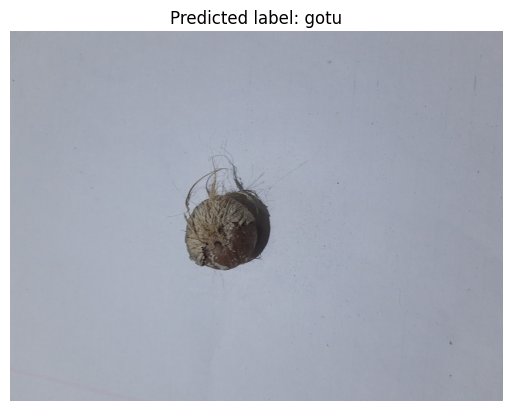

In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib
import os
from PIL import Image
import  matplotlib.pyplot as plt
import pandas as pd

def remove_background(img):
    lower = np.array([200, 200, 200])
    upper = np.array([255, 255, 255])
    thresh = cv2.inRange(img, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    mask = 255 - morph
    result = cv2.bitwise_and(img, img, mask=mask)
    img[mask == 0] = [0, 0, 0]
    return result

def extract_color_features(img):

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    h, s, v = cv2.split(hsv_img)

    features = []
    for channel in [h, s, v]:
        mean = np.mean(channel)
        std = np.std(channel)


        if std == 0:
            skewness = 0
        else:
            skewness = np.mean((channel - mean) ** 3) ** (1./3)


        if np.isnan(mean):
            mean = 0
        if np.isnan(std):
            std = 0
        if np.isnan(skewness):
            skewness = 0

        features.extend([mean, std, skewness])
    return np.array(features)

def extract_texture_features(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    texture_features = np.array([contrast, dissimilarity, homogeneity, energy, correlation, asm])
    return texture_features

def extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")
    img_no_bg = remove_background(img)
    color_features = extract_color_features(img_no_bg)
    texture_features = extract_texture_features(img_no_bg)
    features = np.concatenate((color_features, texture_features))


    expected_length = 15
    if features.shape[0] != expected_length:
        raise ValueError(f"Extracted features have length {features.shape[0]}, but expected {expected_length}.")

    return features

def test_new_image(img_path, model_path='svm_model.joblib', scaler_path='scaler.joblib'):
    svm_model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    img_features = extract_features(img_path)

    imputer = SimpleImputer(strategy='mean')
    img_features = imputer.fit_transform([img_features])

    img_features = scaler.transform(img_features)

    predicted_label = svm_model.predict(img_features)[0]

    label_mapping = {0: '1st class', 1: '2nd class', 2: '3rd class', 3: 'gotu'}
    class_name = label_mapping[predicted_label]

    return class_name


new_image_path = '/content/drive/MyDrive/test/gotuuu/20240617_193059.jpg'
predicted_label = test_new_image(new_image_path)
print(f'Predicted label for the new image: {predicted_label}')
img = Image.open(new_image_path)
plt.imshow(img)
plt.title(f'Predicted label: {predicted_label}')
plt.axis('off')
plt.show()